In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark =SparkSession.builder \
  .master('local[*]') \
  .appName('conversions') \
  .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
  .getOrCreate() 
sqlContext = SQLContext(spark)

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-95e9dcea-46f7-483c-8203-232d914715a0;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 in central
:: resolution report :: resolve 256ms :: artifacts dl 3ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrie

In [2]:
import os
#import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from scipy.optimize import curve_fit
#from scipy.special import zeta
#import nfts.dataset
from matplotlib.pyplot import figure
from pyspark.sql.types import DateType

In [3]:
transfers_df = (spark.read.format('bigquery').option('table', 'ExtendedSqlLiteDataset.transfers')
                        .option('header' , 'true')
                        .option("inferSchema", "true")
                        .load())

In [4]:
transfers_df = transfers_df.withColumn("ctoken", concat_ws(':', transfers_df.nft_address, transfers_df.token_id))

In [5]:
mints_df = (spark.read.format('bigquery').option('table', 'ExtendedSqlLiteDataset.mints')
                        .option('header' , 'true')
                        .option("inferSchema", "true")
                        .load())

In [6]:
mints_df = mints_df.withColumn("ctoken", concat_ws(':', mints_df.nft_address, mints_df.token_id))

In [7]:
mint_times_df = mints_df[['ctoken','timestamp']].dropna()

In [8]:
transfers_with_mint_time = transfers_df.join(mint_times_df.withColumnRenamed('timestamp', 'timestamp_y'),on='ctoken',how='inner')

In [9]:
transfers_with_mint_time = transfers_with_mint_time.withColumn("mint_dts", from_unixtime(transfers_with_mint_time.timestamp_y,"yyyy-MM-dd HH:mm:ss"))

In [10]:
transfers_with_mint_time = transfers_with_mint_time.withColumn("xfer_dts", from_unixtime(transfers_with_mint_time.timestamp,"yyyy-MM-dd HH:mm:ss"))

In [11]:
transfers_with_mint_time = transfers_with_mint_time.withColumn("mint_to_xfer_seconds", transfers_with_mint_time.timestamp-transfers_with_mint_time.timestamp_y)

In [12]:
transfers_with_mint_time = transfers_with_mint_time.withColumn("hour",  from_unixtime(transfers_with_mint_time.timestamp_y,"HH"))

In [13]:
transfers_with_mint_time = transfers_with_mint_time.withColumn("hourofweek", transfers_with_mint_time.hour +dayofweek(transfers_with_mint_time.mint_dts).alias('day')* 24)

In [14]:
transfers_with_mint_time = transfers_with_mint_time.withColumn("day_of_year", dayofyear(transfers_with_mint_time.mint_dts).alias('day'))

In [15]:
transfers_with_mint_time = transfers_with_mint_time.drop("eventId","transaction_hash","block_number","nft_address","token_id","from_address","to_address","transaction_value", "timestamp_y","mint_dts","xfer_dts")

In [16]:
transfers_with_mint_time.show(2)

+--------------------+----------+--------------------+----+----------+-----------+
|              ctoken| timestamp|mint_to_xfer_seconds|hour|hourofweek|day_of_year|
+--------------------+----------+--------------------+----+----------+-----------+
|0x000000000437b3C...|1626933233|               528.0|  05|     125.0|        203|
|0x000000000437b3C...|1628922018|                83.0|  06|     174.0|        226|
+--------------------+----------+--------------------+----+----------+-----------+
only showing top 2 rows



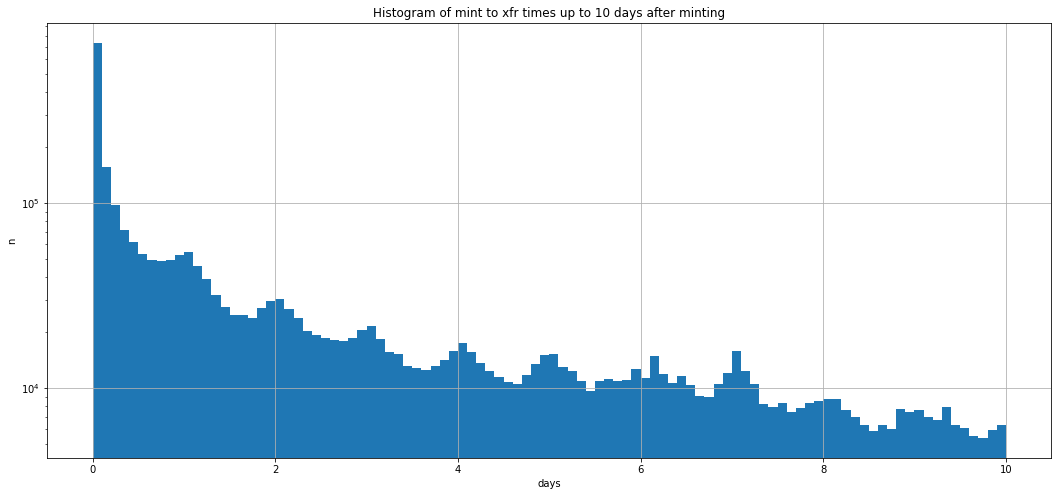

In [15]:
figure(figsize=(18,8))

mint_to_xfer_seconds = transfers_with_mint_time.sort("mint_to_xfer_seconds").select('mint_to_xfer_seconds').toPandas()['mint_to_xfer_seconds']

_, _, _ = plt.hist(mint_to_xfer_seconds/86400, bins=100,log='False',range=(0,10))
plt.xlabel('days')
plt.ylabel('n')
plt.title('Histogram of mint to xfr times up to 10 days after minting')
plt.grid(True)
plt.show()

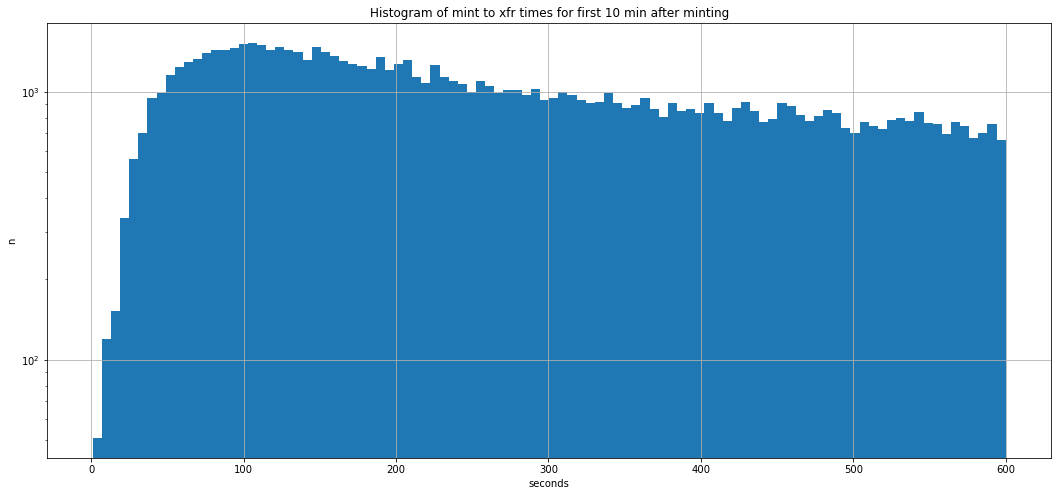

In [17]:
figure(figsize=(18,8))

mint_to_xfer_seconds = transfers_with_mint_time.sort("mint_to_xfer_seconds").select('mint_to_xfer_seconds').toPandas()['mint_to_xfer_seconds']

_, _, _ = plt.hist(mint_to_xfer_seconds, bins=100,log='False',range=(1,600))
# note the range starts at 1 to exclude mint-transfer pairs
plt.xlabel('seconds')
plt.ylabel('n')
plt.title('Histogram of mint to xfr times for first 10 min after minting')
plt.grid(True)
plt.show()

In [17]:
early_bites = transfers_with_mint_time[transfers_with_mint_time.mint_to_xfer_seconds.between(1,70)].toPandas()

In [18]:
early_by_days = early_bites.groupby('hourofweek').ctoken.count()

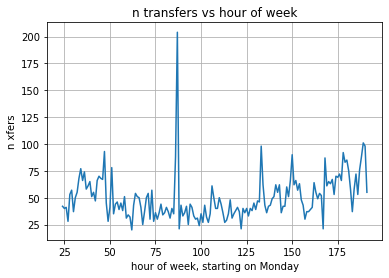

In [19]:
plt.plot(early_by_days)
plt.xlabel('hour of week, starting on Monday')
plt.ylabel('n xfers')
plt.title('n transfers vs hour of week')
plt.grid(True)
plt.show()

In [20]:
tper_day = transfers_with_mint_time.toPandas().groupby('day_of_year').ctoken.count()

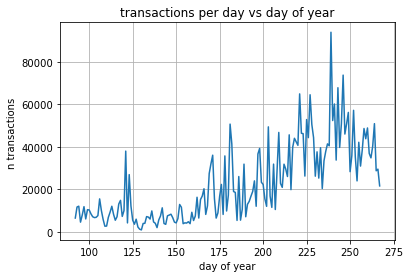

In [21]:
plt.plot(tper_day[1:-1])
# first and last day are probably partial data
plt.xlabel('day of year')
plt.ylabel('n transactions ')
plt.title('transactions per day vs day of year')
plt.grid(True)
plt.show()